In [ ]:
from pypots.data import load_specific_dataset
import tsdb
import numpy as np
import pandas as pd
from pygrinder import mcar, mnar_t

conf_pars = tsdb.utils.config.read_configs()
conf = {'path': {'data_home' : '/home/edfilatov'}}
tsdb.utils.config.write_configs(conf_pars, conf)

data = tsdb.load("electricity_load_diagrams")
data = data['X']

data_electricity_2014 = data[(data.index > pd.Timestamp('2014-01-01'))]

X_ori = data_electricity_2014.to_numpy().reshape(-1, 96, 370)
X = np.copy(X_ori)
X_ori = X_ori[:36, :, :10]
X = X[36:, :, 10]
X_ori_missed = mcar(X_ori, 0.1)
dataset = {"X" : X}

2024-05-07 23:47:58 [INFO]: Wrote new configs to config.ini successfully.
2024-05-07 23:47:58 [INFO]: You're using dataset electricity_load_diagrams, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/electricity_load_diagrams
2024-05-07 23:47:58 [INFO]: Dataset electricity_load_diagrams has already been downloaded. Processing directly...
2024-05-07 23:47:58 [INFO]: Dataset electricity_load_diagrams has already been cached. Loading from cache directly...
2024-05-07 23:47:58 [INFO]: Loaded successfully!


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar, mnar_t
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.imputation import CSDI
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_rmse
from pypots.utils.metrics import calc_mre
from pypots.utils.metrics import calc_quantile_crps
from scipy import stats

def calc_nlpd(y_pred, y_true, mask, y_pred_std):
    metric = (((y_true - y_pred)**2) * mask) / ((2 * y_pred_std**2) + 1e-12) + (np.log(y_pred_std + 1e-12) * mask) + 0.5 * np.log(2 * np.pi)

    return metric.sum() / (mask.sum() + 1e-12)

def calc_picp(y_pred, y_true, mask, y_pred_std, alpha=0.90):
    p_left, p_right = stats.norm.interval(confidence=alpha, loc=y_pred, scale=y_pred_std)
    metric = (y_true > p_left) * (y_true <= p_right)

    return (metric * mask).sum() / (mask.sum() + 1e-12)

n_steps=X.shape[1]
n_features=X.shape[2]
print(X.shape)

(365, 96, 10)


In [ ]:
data

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [ ]:
csdi = CSDI(n_features=n_features, n_layers=4, n_heads=8, n_channels=64, d_time_embedding=128, d_feature_embedding=128, d_diffusion_embedding=128, epochs=150, saving_path='csdi_model')

csdi.fit(dataset)

2024-05-07 23:47:59 [INFO]: No given device, using default device: cuda
2024-05-07 23:47:59 [INFO]: Model files will be saved to csdi_model/20240507_T234759
2024-05-07 23:47:59 [INFO]: Tensorboard file will be saved to csdi_model/20240507_T234759/tensorboard
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-05-07 23:48:01 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 472,129
2024-05-07 23:48:18 [INFO]: Epoch 001 - training loss: 0.9273
2024-05-07 23:48:21 [INFO]: Epoch 002 - training loss: 0.8322
2024-05-07 23:48:24 [INFO]: Epoch 003 - training loss: 0.7420
2024-05-07 23:48:26 [INF

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.0001
csdi.epochs = 30
csdi.fit(dataset)

2024-05-07 23:55:12 [INFO]: Epoch 001 - training loss: 0.5702
2024-05-07 23:55:15 [INFO]: Epoch 002 - training loss: 0.5659
2024-05-07 23:55:18 [INFO]: Epoch 003 - training loss: 0.5664
2024-05-07 23:55:21 [INFO]: Epoch 004 - training loss: 0.5583
2024-05-07 23:55:23 [INFO]: Epoch 005 - training loss: 0.5750
2024-05-07 23:55:26 [INFO]: Epoch 006 - training loss: 0.5489
2024-05-07 23:55:29 [INFO]: Epoch 007 - training loss: 0.5598
2024-05-07 23:55:32 [INFO]: Epoch 008 - training loss: 0.5727
2024-05-07 23:55:34 [INFO]: Epoch 009 - training loss: 0.5477
2024-05-07 23:55:37 [INFO]: Epoch 010 - training loss: 0.5436
2024-05-07 23:55:40 [INFO]: Epoch 011 - training loss: 0.5892
2024-05-07 23:55:43 [INFO]: Epoch 012 - training loss: 0.5668
2024-05-07 23:55:45 [INFO]: Epoch 013 - training loss: 0.5297
2024-05-07 23:55:48 [INFO]: Epoch 014 - training loss: 0.5286
2024-05-07 23:55:51 [INFO]: Epoch 015 - training loss: 0.5739
2024-05-07 23:55:54 [INFO]: Epoch 016 - training loss: 0.5681
2024-05-

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.00001
csdi.epochs = 20
csdi.fit(dataset)

2024-05-07 23:56:35 [INFO]: Epoch 001 - training loss: 0.5562
2024-05-07 23:56:38 [INFO]: Epoch 002 - training loss: 0.5624
2024-05-07 23:56:41 [INFO]: Epoch 003 - training loss: 0.5709
2024-05-07 23:56:44 [INFO]: Epoch 004 - training loss: 0.5850
2024-05-07 23:56:46 [INFO]: Epoch 005 - training loss: 0.5421
2024-05-07 23:56:49 [INFO]: Epoch 006 - training loss: 0.5648
2024-05-07 23:56:52 [INFO]: Epoch 007 - training loss: 0.5457
2024-05-07 23:56:54 [INFO]: Epoch 008 - training loss: 0.5523
2024-05-07 23:56:57 [INFO]: Epoch 009 - training loss: 0.5893
2024-05-07 23:57:00 [INFO]: Epoch 010 - training loss: 0.5691
2024-05-07 23:57:03 [INFO]: Epoch 011 - training loss: 0.5423
2024-05-07 23:57:05 [INFO]: Epoch 012 - training loss: 0.5649
2024-05-07 23:57:08 [INFO]: Epoch 013 - training loss: 0.5492
2024-05-07 23:57:11 [INFO]: Epoch 014 - training loss: 0.5673
2024-05-07 23:57:14 [INFO]: Epoch 015 - training loss: 0.5755
2024-05-07 23:57:16 [INFO]: Epoch 016 - training loss: 0.5784
2024-05-

In [ ]:
n_preds = 30
imputation_csdi = csdi.predict(dataset, n_sampling_times=n_preds)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X_ori_missed) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

In [ ]:
mae_csdi = calc_mae(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_csdi = calc_rmse(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_csdi = calc_mre(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_csdi = calc_quantile_crps(imputation_csdi['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_csdi = calc_nlpd(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))
picp_csdi = calc_picp(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi)

10.342785068684991 20.034484304358916 0.1365664885199729 0.2437999875921952 13.282005113670577 0.8756492950510874


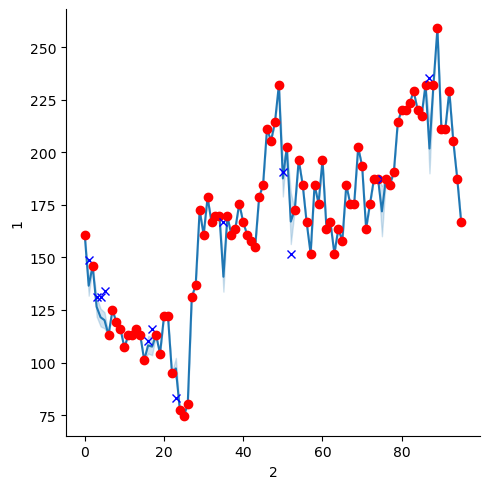

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

day = 132
station = 5

d = pd.DataFrame(columns=['1', '2'])
for i in range(n_preds):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')


In [ ]:
saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=200, saving_path='saits')
saits.fit(dataset)

2024-05-08 00:19:30 [INFO]: No given device, using default device: cuda
2024-05-08 00:19:30 [INFO]: Model files will be saved to saits/20240508_T001930
2024-05-08 00:19:30 [INFO]: Tensorboard file will be saved to saits/20240508_T001930/tensorboard
2024-05-08 00:19:30 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,333,424
2024-05-08 00:19:30 [INFO]: Epoch 001 - training loss: 147.1549
2024-05-08 00:19:31 [INFO]: Epoch 002 - training loss: 142.9134
2024-05-08 00:19:31 [INFO]: Epoch 003 - training loss: 139.2861
2024-05-08 00:19:32 [INFO]: Epoch 004 - training loss: 134.3166
2024-05-08 00:19:32 [INFO]: Epoch 005 - training loss: 127.9241
2024-05-08 00:19:33 [INFO]: Epoch 006 - training loss: 121.2831
2024-05-08 00:19:33 [INFO]: Epoch 007 - training loss: 114.0041
2024-05-08 00:19:33 [INFO]: Epoch 008 - training loss: 106.6132
2024-05-08 00:19:34 [INFO]: Epoch 009 - training loss: 100.2934
2024-05-08 00:19:34 [INFO]: Epoch 010 - training lo

In [ ]:
imputation_saits = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_saits = calc_mae(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_saits = calc_rmse(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_saits = calc_mre(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_saits = calc_quantile_crps(np.expand_dims(imputation_saits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_saits, rmse_saits, mape_saits, crps_saits)

8.899991875673715 15.09727696886258 0.11751579775132857 0.11751580238342285


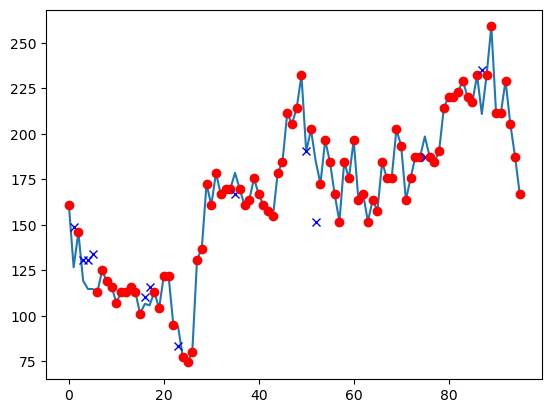

In [ ]:
plt.plot(imputation_saits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import BRITS

brits = BRITS(n_steps=n_steps, n_features=n_features, rnn_hidden_size=128, epochs=200, saving_path='brits')
brits.fit(dataset)

2024-05-08 00:20:30 [INFO]: No given device, using default device: cuda
2024-05-08 00:20:30 [INFO]: Model files will be saved to brits/20240508_T002030
2024-05-08 00:20:30 [INFO]: Tensorboard file will be saved to brits/20240508_T002030/tensorboard
2024-05-08 00:20:30 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 159,856
2024-05-08 00:20:50 [INFO]: Epoch 001 - training loss: 161.1064
2024-05-08 00:21:06 [INFO]: Epoch 002 - training loss: 153.7631
2024-05-08 00:21:17 [INFO]: Epoch 003 - training loss: 146.5354
2024-05-08 00:21:26 [INFO]: Epoch 004 - training loss: 139.6395
2024-05-08 00:21:38 [INFO]: Epoch 005 - training loss: 133.3180
2024-05-08 00:21:52 [INFO]: Epoch 006 - training loss: 127.7585
2024-05-08 00:22:05 [INFO]: Epoch 007 - training loss: 122.3036
2024-05-08 00:22:19 [INFO]: Epoch 008 - training loss: 118.0252
2024-05-08 00:22:34 [INFO]: Epoch 009 - training loss: 113.9894
2024-05-08 00:22:47 [INFO]: Epoch 010 - training loss

In [ ]:
imputation_brits = brits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_brits = calc_mae(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_brits = calc_rmse(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_brits = calc_mre(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_brits = calc_quantile_crps(np.expand_dims(imputation_brits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_brits, rmse_brits, mape_brits, crps_brits)

10.713116876768332 18.179962444444477 0.14145636240610063 0.14145635303698087


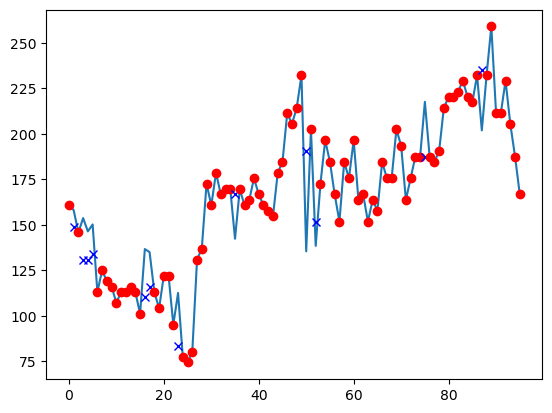

In [ ]:
plt.plot(imputation_brits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import GPVAE

gp_vae = GPVAE(n_steps=n_steps, n_features=n_features, latent_size=256, epochs=200, encoder_sizes=(256, 256), decoder_sizes=(256, 256), saving_path='gp_vae')
gp_vae.fit(dataset)

2024-05-08 01:05:42 [INFO]: No given device, using default device: cuda
2024-05-08 01:05:42 [INFO]: Model files will be saved to gp_vae/20240508_T010542
2024-05-08 01:05:42 [INFO]: Tensorboard file will be saved to gp_vae/20240508_T010542/tensorboard
2024-05-08 01:05:42 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 405,258
2024-05-08 01:05:48 [INFO]: Epoch 001 - training loss: 10956013.4167
2024-05-08 01:05:55 [INFO]: Epoch 002 - training loss: 1720140.2708
2024-05-08 01:06:04 [INFO]: Epoch 003 - training loss: 892341.2188
2024-05-08 01:06:12 [INFO]: Epoch 004 - training loss: 681001.4427
2024-05-08 01:06:20 [INFO]: Epoch 005 - training loss: 590054.5052
2024-05-08 01:06:28 [INFO]: Epoch 006 - training loss: 558457.9323
2024-05-08 01:06:36 [INFO]: Epoch 007 - training loss: 542092.9219
2024-05-08 01:06:44 [INFO]: Epoch 008 - training loss: 532011.5807
2024-05-08 01:06:53 [INFO]: Epoch 009 - training loss: 520646.5469
2024-05-08 01:07:02 [

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
imputation_gp_vae = gp_vae.predict(dataset, n_sampling_times=3)  # impute the originally-missing values and artificially-missing values
mae_gp_vae = calc_mae(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_gp_vae = calc_rmse(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_gp_vae = calc_mre(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_gp_vae = calc_quantile_crps(imputation_gp_vae['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_gp_vae = calc_nlpd(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))
picp_gp_vae = calc_picp(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae)

11.092318723090305 17.99057586336833 0.14646335658112958 0.14646335652000025 266445435497317.62 0.0


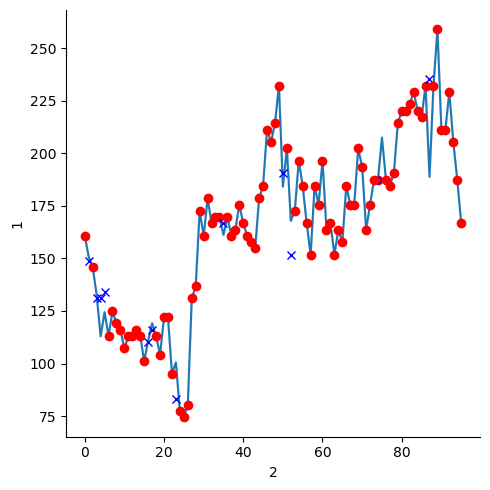

In [ ]:
d = pd.DataFrame(columns=['1', '2'])
for i in range(3):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
np.save('imputation_csdi_electricity_3', imputation_csdi['imputation'])
np.save('imputation_saits_electricity_3', imputation_saits['imputation'])
np.save('imputation_brits_electricity_3', imputation_brits['imputation'])
np.save('imputation_gp_vae_electricity_3', imputation_csdi['imputation'])

In [ ]:
pd.DataFrame([[mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi],
             [mae_saits, rmse_saits, mape_saits, crps_saits, -1, -1],
             [mae_brits, rmse_brits, mape_brits, crps_brits, -1, -1],
             [mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae]],
             index=['CSDI', 'SAITS', 'BRITS', 'GP-VAE'], columns=['MAE', 'RMSE', 'MAPE', 'CRPS', 'NLPD', 'PICP'])

,MAE,RMSE,MAPE,CRPS,NLPD,PICP
CSDI,10.342785,20.034484,0.136566,0.243800,1.328201e+01,0.875649
SAITS,8.899992,15.097277,0.117516,0.117516,-1.000000e+00,-1.000000
BRITS,10.713117,18.179962,0.141456,0.141456,-1.000000e+00,-1.000000
GP-VAE,11.092319,17.990576,0.146463,0.146463,2.664454e+14,0.000000


In [ ]:
days = np.random.randint(36, size=10)
stations = np.random.randint(10, size=10)

<Figure size 2000x2000 with 0 Axes>

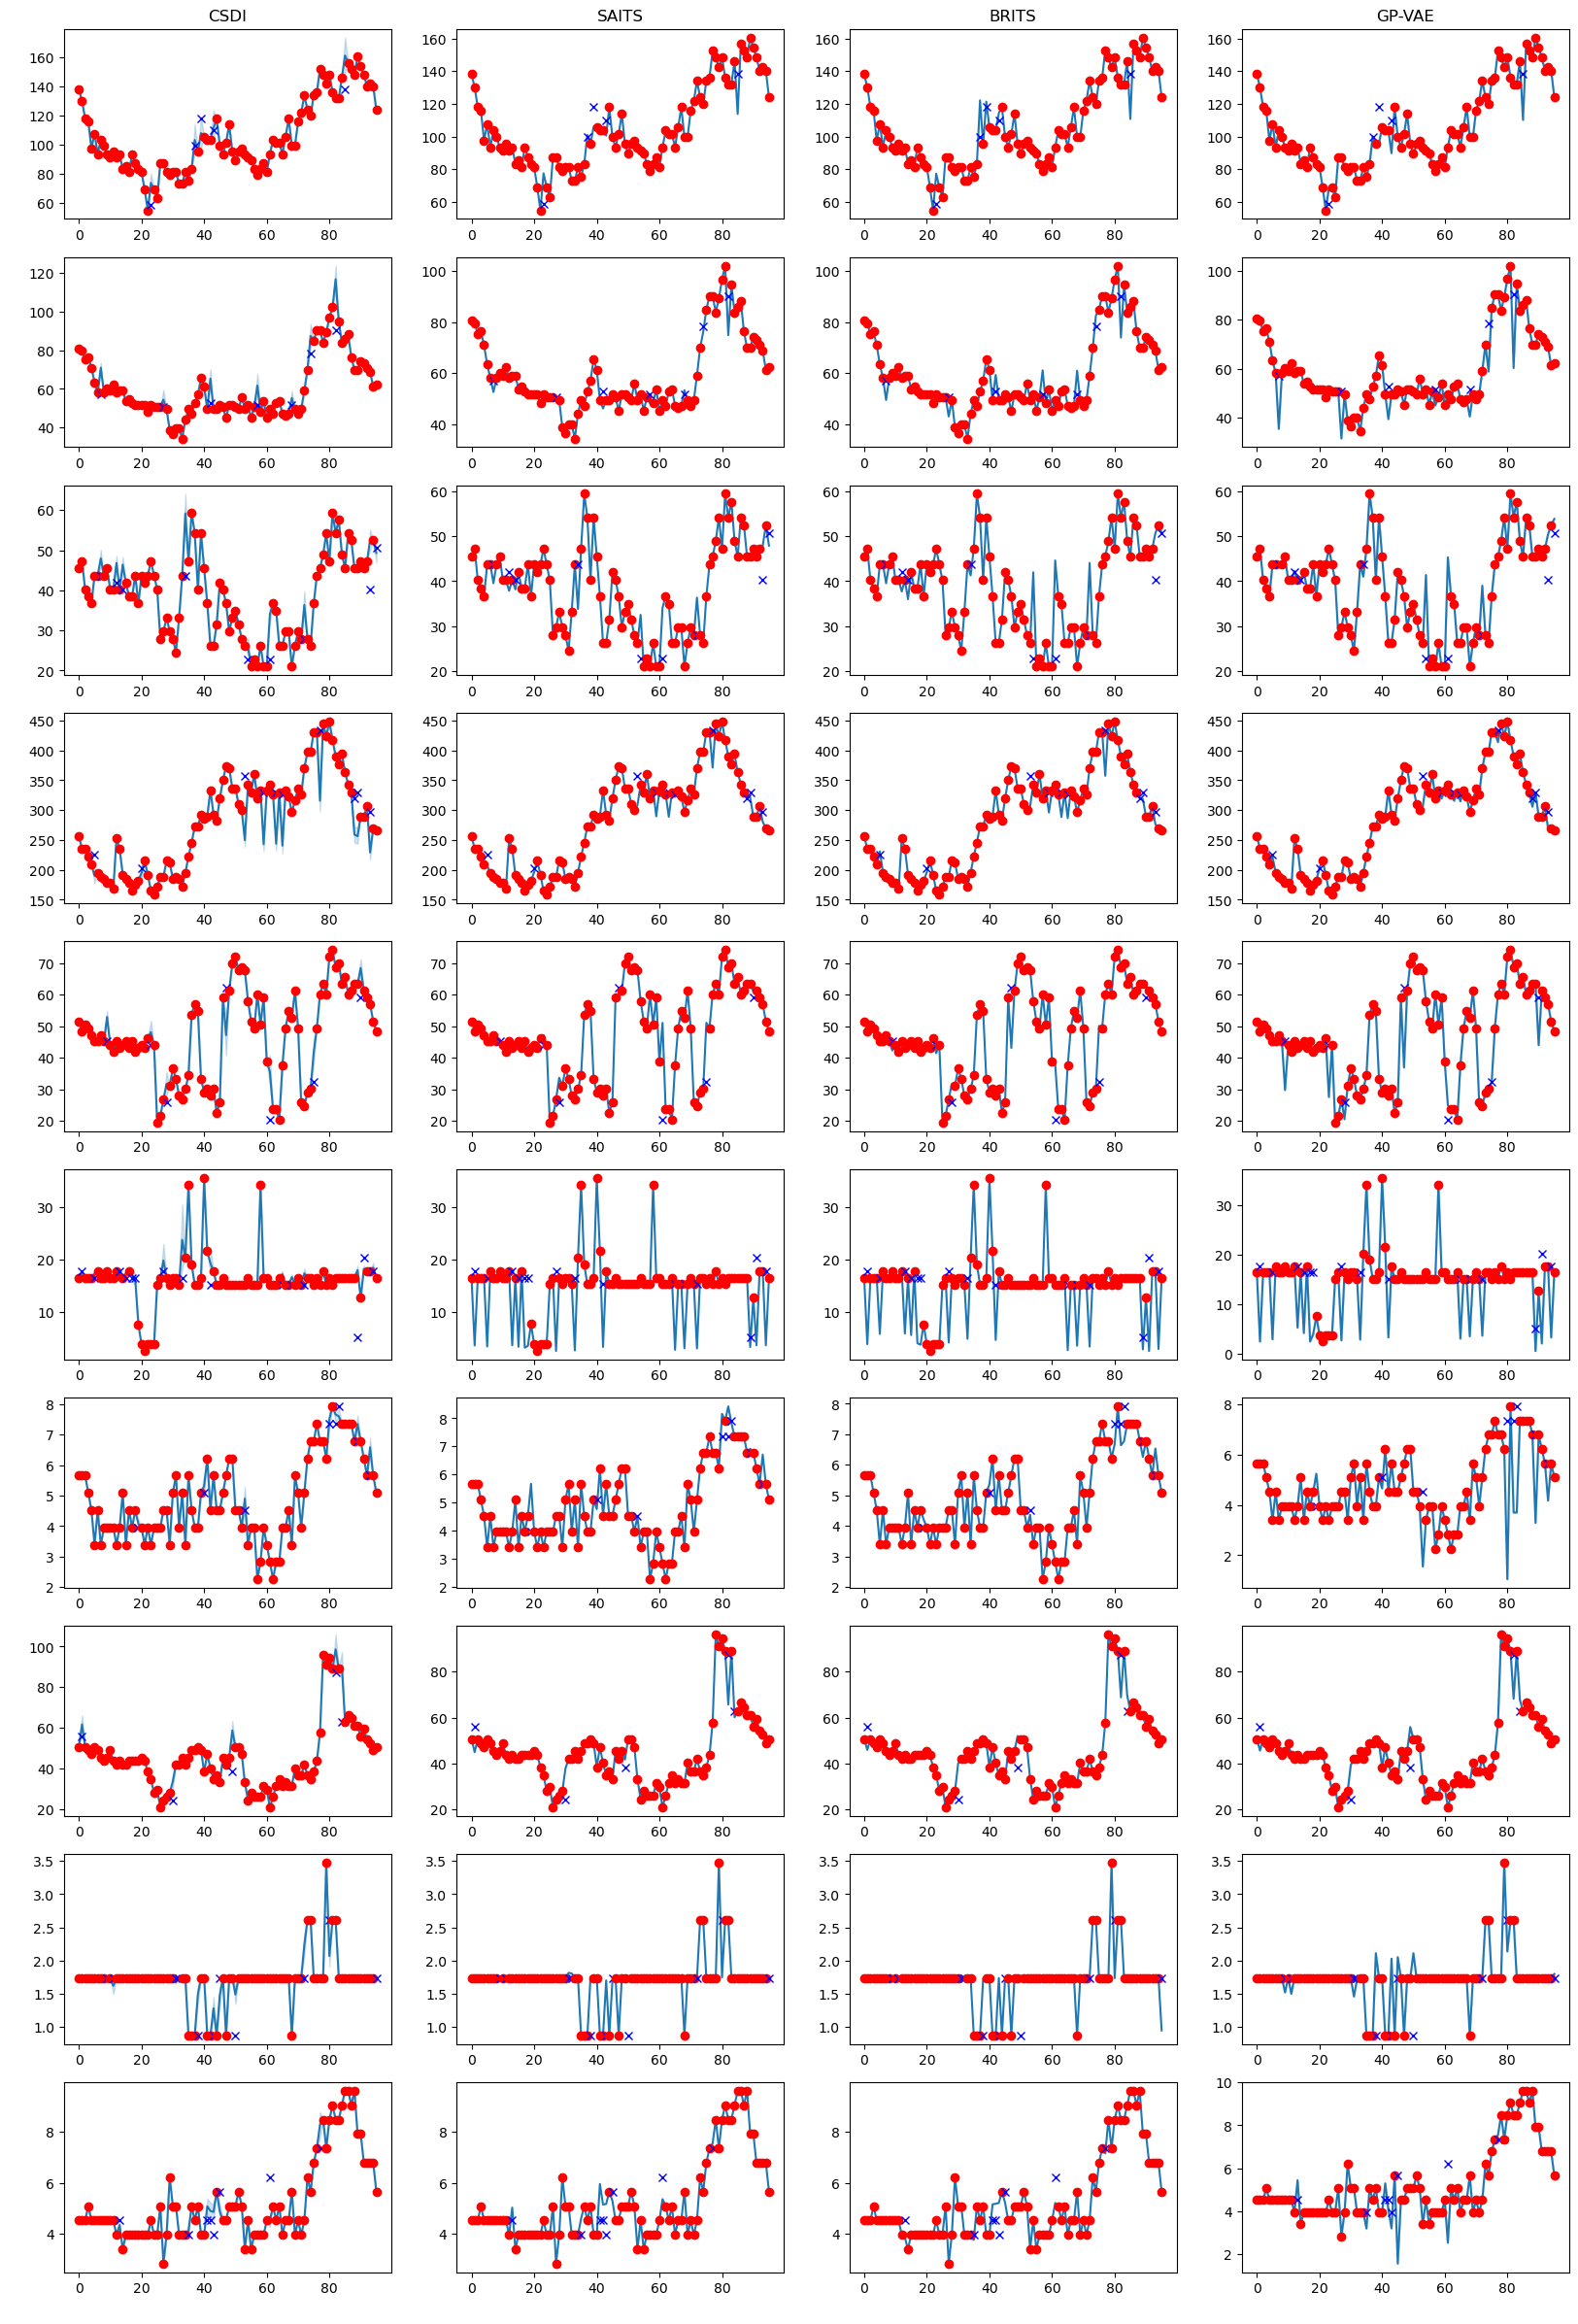

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))
fig, ax = plt.subplots(10, 4)
fig.set_figheight(30)
fig.set_figwidth(20)

ax[0][0].set_title('CSDI')
ax[0][1].set_title('SAITS')
ax[0][2].set_title('BRITS')
ax[0][3].set_title('GP-VAE')

for ids, day_station in enumerate(zip(days, stations)):
    day = day_station[0]
    station = day_station[1]
    n_preds = 30

    ax[ids][0].set_xlabel(' ')
    ax[ids][1].set_xlabel(' ')
    ax[ids][2].set_xlabel(' ')
    ax[ids][3].set_xlabel(' ')
    ax[ids][0].set_ylabel(' ')
    ax[ids][1].set_ylabel(' ')
    ax[ids][2].set_ylabel(' ')
    ax[ids][3].set_ylabel(' ')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(n_preds):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 0])# kind='line',
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 0].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 1].plot(imputation_saits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 1].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 2].plot(imputation_brits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 2].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(3):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 3])# kind='line',
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 3].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')